In [1]:
import pandas as pd
import numpy as np
from spacy.lang.en import English
from spacy.lang.es import Spanish
import xml.etree.ElementTree as et 
import spacy
import re
import nltk
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tnrange, tqdm_notebook, tqdm
import torch.optim as optim
import pylab



en = English()


In [2]:
spacy_nlp = spacy.load('en_core_web_sm')


In [3]:
labels = pd.DataFrame(columns=['user_id', "type", "sex"])
f = open("pan19-author-profiling-training-2019-02-18\en\\truth.txt", "r")
for line in f:
    labels = labels.append(pd.DataFrame([line.rstrip('\n').split(':::')], columns=['user_id', "type", "sex"]))

labels

,user_id,type,sex
0,b2d5748083d6fdffec6c2d68d4d4442d,bot,bot
0,2bed15d46872169dc7deaf8d2b43a56,bot,bot
0,25395a7dbd2caa3d828bb3dbd57d8857,bot,bot
0,1c9f161414334b286c4dc70163744390,bot,bot
0,1da1f87b3dc778f28268eec70ce94f19,bot,bot
...,...,...,...
0,4d860a0ce265614a7231e69b4373814e,human,male
0,d01c256f2f28dc753ee2e0ca7d0c0fc2,human,male
0,b71cb5dda74d9974ed2f546e591a9ff7,human,male
0,60d068f9cafb656431e62a6542de2dc0,human,male


In [4]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))



In [5]:
tweets = pd.DataFrame()
i=0
for user in labels['user_id']:
    xtree = et.parse("pan19-author-profiling-training-2019-02-18\en\\"+user+".xml")
    xroot = xtree.getroot()
    
    # chwilowo nie usuwamy rt, jest szansa, że ludzie częściej retweetują
    # ogólnie czyszczenie może spowodować usunięcie czynników ludzkich, chwilowo zostawiamy
    rows = [re.sub(r'\W',' ',xroot[0][i].text.lower()) for i in range(len(xroot[0]))] # removing nonwords
    rows = [re.sub(r'\s+',' ', row) for row in rows] # removing double whitespace
    rows = [re.sub(r'\d+', '', row) for row in rows] # removing numbers
    rows = [nltk.word_tokenize(row) for row in rows] # tokenization
    rows = [[i for i in row if not i in stop_words] for row in rows] #removing stopwords
    tweets[user] = rows
    if i%100==0:
        print(i)
    i+=1
tweets


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


,b2d5748083d6fdffec6c2d68d4d4442d,2bed15d46872169dc7deaf8d2b43a56,25395a7dbd2caa3d828bb3dbd57d8857,1c9f161414334b286c4dc70163744390,1da1f87b3dc778f28268eec70ce94f19,bd4286bfafb8a35b8e132a396b884e07,af61c4c017f246da69285497baf3dc0b,7a36090b20e7bddbe55561c52f959041,5183ff5bedcab9a6a301ff04e27166cd,6ac10734f35a773e9f2209f8668fffdf,...,1521f9059d3fd5a587bb31facac9ef0,5b4c77f0853cab0f5b2dc8891f47e07,b530113f7fb35f795693a039e9c980,6f41096c0badc574b6fbb41876a6c65b,321fe67737d3ea46ef111bc5ba20ebae,4d860a0ce265614a7231e69b4373814e,d01c256f2f28dc753ee2e0ca7d0c0fc2,b71cb5dda74d9974ed2f546e591a9ff7,60d068f9cafb656431e62a6542de2dc0,c6e5e9c92fb338dc0e029d9ea22a4358
0,"[backend, developer, responsibilities, develop...","[data, processor, description, msw, ars, perfo...","[hotels, data, specialist, company, hopper, be...","[director, engineering, supervisor, director, ...","[development, analyst, ii, development, analys...","[ab, initio, etl, developer, ab, initio, etl, ...","[senior, software, engineer, itd, job, pt, sen...","[associate, level, iii, file, transfer, engine...","[automotive, infotainment, systems, architect,...","[principal, systems, engineer, principal, syst...",...,"[the_gospels, world, hates, keep, mind, hated,...","[really, partner, music, would, much, fun, tak...","[finished, editing, photos, morning, check, fa...","[themanlysamurai, meganbatoon, shes, pweerfect]","[heard, capital, kings, remix, way, yet, check...","[glasses, frame, broke, im, blind, like, serio...","[themanlysamurai, true, aint, got, moneey, fo,...","[themanlysamurai, good, put, hashtag, aint, do...","[mandy, moore, hope, cover, http, co, lspwbqrj...","[late, night, video, editing, finishing, pre, ..."
1,"[senior, java, python, developer, software, ar...","[team, leader, applications, dc, team, leader,...","[data, scientist, job, data, scientist, mounta...","[administrative, assistant, data, encoder, see...","[software, engineer, software, engineer, requi...","[senior, software, engineer, grantmaking, blac...","[cybersecurity, job, fair, delta, resources, i...","[position, multiple, positions, available, fol...","[senior, software, developer, lead, senior, so...","[senior, integration, test, engineer, br, seni...",...,"[sannimmairura, wan, na, know, chosen, ephesians]","[much, fun, performance, mode, fl, studio]","[photoset, sfu, burnaby, http, co, pkeliacd]","[celebrity, crush, meganbatoon]","[heard, dark, light, decaiman, soundcloud, htt...","[anyone, knows, put, together, pre, decent, mu...","[themanlysamurai, give, monday, well, least, s...","[themanlysamurai, trying, find, car, productiv...","[finally, finished, recording, cover, hope, el...","[really, want, pet, dog, allergic]"
2,"[senior, symfony, php, developer, seeking, hig...","[manager, applications, manager, applications,...","[senior, manager, information, security, gover...","[senior, associate, marketing, cloud, technica...","[manager, software, engineering, r, capital, o...","[sr, software, engineer, sr, software, enginee...","[engineering, engineering, applied, materials,...","[sr, project, manager, join, emergent, biosolu...","[front, end, developer, mid, employee, type, f...","[customer, success, manager, redwood, city, ca...",...,"[rt, nicklaparra, much, hipster, weigh, instag...","[performance, mode, lt, flstudio]","[totally, forgot, upload, edit, photos, took, ...","[yomyomf, replied, one, tweets, fanboying]","[today, work, comes, end, studio, dawn, comes,...","[themanlysamurai, totally, party, sure, happen]","[rios, attitude, though, youdapunchingbag, pac...","[frozen, goooood, movie]","[found, gbaios, two, finally, guess, going, pl...","[advice, making, melodies, producertips]"
3,"[advanced, weapons, amp, lethality, solutions,...","[software, engineer, software, engineer, capit...","[principal, technology, development, engineer,...","[manager, network, services, manager, network,...","[multiple, positions, computers, headquartered...","[system, administrator, sa, level, ts, sci, w

In [6]:
labels_test = pd.DataFrame(columns=['user_id', "type", "sex"])
f = open("pan19-author-profiling-test-2019-04-29\en\\truth.txt", "r")
for line in f:
    labels_test = labels_test.append(pd.DataFrame([line.rstrip('\n').split(':::')], columns=['user_id', "type", "sex"]))

labels_test

,user_id,type,sex
0,c7b4a77293eb19d839400b2965df0a4,bot,bot
0,d7c88083b8790d7dfddd0cb5e84097f7,bot,bot
0,8030eb5a6032a80f7dd4bca6b9bd7c9c,bot,bot
0,ef86b54e0f1a87d4065ea80037063d49,bot,bot
0,40ed275c5b025954a05993216316d875,bot,bot
...,...,...,...
0,ee7505dbe95b24cb714a41487cf5bacb,human,male
0,c4926315cf5bed284fc3c72f66c81228,human,male
0,3bae53be92d9e8e8ae573514deeab0c3,human,male
0,399c868b10d8424641c2ab99a971fe0d,human,male


In [7]:
tweets_test = pd.DataFrame()
i=0
for user in labels_test['user_id']:
    xtree = et.parse("pan19-author-profiling-test-2019-04-29\en\\"+user+".xml")
    xroot = xtree.getroot()
    
    # chwilowo nie usuwamy rt, jest szansa, że ludzie częściej retweetują
    # ogólnie czyszczenie może spowodować usunięcie czynników ludzkich, chwilowo zostawiamy
    rows = [re.sub(r'\W',' ',xroot[0][i].text.lower()) for i in range(len(xroot[0]))] # removing nonwords
    rows = [re.sub(r'\s+',' ', row) for row in rows] # removing double whitespace
    rows = [re.sub(r'\d+', '', row) for row in rows] # removing numbers
    rows = [nltk.word_tokenize(row) for row in rows] # tokenization
    rows = [[i for i in row if not i in stop_words] for row in rows] #removing stopwords
    tweets_test[user] = rows
    if i%100==0:
        print(i)
    i+=1
tweets_test

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


,c7b4a77293eb19d839400b2965df0a4,d7c88083b8790d7dfddd0cb5e84097f7,8030eb5a6032a80f7dd4bca6b9bd7c9c,ef86b54e0f1a87d4065ea80037063d49,40ed275c5b025954a05993216316d875,5a2e66063ff307ed411ec0ddef92f7ab,86de05c6a81cae7880bbdbafecffae97,489a588136787e1042f00368357126d5,c693f7db69500e6db34c378af2e5f10e,df17548ae048896d8a8408b69b3ff392,...,7482b49ae7ee86fe18682fbc140b1c96,bb73ab3ffdd238a2862327ac321a8f61,60b803e1faeb89ea373bca0c86cc8666,195e385d579b19ce01a78c3f748807b0,9a93bca331186b55642e0e3c4ca56a6d,ee7505dbe95b24cb714a41487cf5bacb,c4926315cf5bed284fc3c72f66c81228,3bae53be92d9e8e8ae573514deeab0c3,399c868b10d8424641c2ab99a971fe0d,b456f9cb13a669020c77016a1568dd28
0,"[police, chief, son, charged, beating, elderly...","[rep, jim, jordan, announces, long, shot, bid,...","[imran, khan, elected, prime, minister, offers...","[latest, trump, lawyer, stormy, daniels, deal,...","[trauma, man, male, fury, fear, rises, gop, de...","[matthew, shepard, murder, changed, america, b...","[certified, medical, assistant, cma, neurology...","[netflix, posts, impressive, earnings, subscri...","[direct, support, professional, residential, j...","[speech, chiefs, police, trump, advocates, sto...",...,"[good, turn, grantonyouth, community, engageme...","[headline, bbcscotlandnews, hearts, v, aberdee...","[think, rather, missed, central, point, https,...","[gerryhassan, workers, need, clarity, amp, pro...","[edinburgh_cc, st, marys, street, joke, cars, ...","[clueless, scotland, manager, survive, another...","[cllrcammyday, benmacpherson, deidrebrock, vic...","[look, forward, new, city, edinburgh, council,...","[rt, deray, lies, effortlessly, https, co, xxo...","[docandrewmurray, successfully, completed, sti..."
1,"[airline, employee, steals, plane, seattle, ai...","[andrew, brunson, pastor, prompting, sanctions...","[kerala, floods, live, updates, water, level, ...","[real, plaidshirtguy, removed, trump, rally, v...","[ex, kavanaugh, classmate, wants, fbi, examine...","[certified, nursing, assistants, cna, pediatri...","[coaches, poll, week, top, rankings, released,...","[medical, records, health, information, manage...","[phlebotomist, norcross, ga, phlebotomist, nor...","[registered, nurse, hospice, prn, seving, king...",...,"[read, comment, sign, petition, vital, local, ...","[thank, patrick, thistle, best, wishes, offici...","[vickiredpath, game, ayrshire, match, magic]","[gerryhassan, would, still, think, livelihood,...","[bbcnews, saying, nothing, media, bus, shot, r...","[heard, mr, strachan, say, chris, martin, outs...","[community, spirit, great, job, grantonyouth, ...","[rt, davemwallace, invitation, views, social, ...","[ksbscotland, edinburgh_cc, north_team, runnin...","[thanks, people, doune, bridge, allan, dunblan..."
2,"[jury, awards, terminally, ill, man, million, ...","[mueller, examining, trump, tweets, wide, rang...","[two, shot, florida, high, school, football, g...","[mother, black, man, shot, dead, white, dallas...","[chinese, warship, nearly, hits, us, destroyer...","[paramedic, job, id, position, type, full, tim...","[physician, full, time, family, medicine, inte...","[dialysis, registered, nurse, center, rn, davi...","[trashing, american, values, biden, hold, back...","[medical, assistant, cert, wmg, urogynecology,...",...,"[paul, godzik, edinburgh, gov, uk, cammy, day,...","[rt, lrozen, offshore, power, players, https, ...","[nicely, killie, https, co, rrgxzbz]","[horrendous, numbergov, https, co, vfvvqhahe]","[could, provide, service, meets, customer, dem...","[clueless, anaemic, utterly, bizarre, team, ch...","[https, co, slslvdqws, like, fb, page, help, u...","[rt, acgrayling, trump, preparing, war, anyone...","[truth, despotic, character, hated, tyrants, r...","[stirling, marathon, day, en, route, good, luc..."
3,"[omarosa, manigault, newman, says, refused, hu...","[former, cricket, great, imran, khan, claims, ...","[ap, omarosa, treasure, trove, tapes, videos, ...","[california, delta, fire, shuts, busy, freeway...","[greg, ab

Możemy operować na zdaniach lub na słowach.
1. Przekształcamy zdania w wektory poprzez BOW
-tracimy miejsca w zdaniu
2. Przekształcamy słowa w wektory, a zdania jako listę tych wektorów
-potencjalnie bardzo duże wejście

In [8]:
wordfreq = {}
for user in labels['user_id']:
    for sentence in tweets[user]:
        #tokens = nltk.word_tokenize(sentence)
        for token in sentence:
            if token not in wordfreq.keys():
                wordfreq[token] = 1
            else:
                wordfreq[token] += 1

In [9]:
len(wordfreq)

449532

In [10]:
import heapq
most_freq = heapq.nlargest(5000, wordfreq, key=wordfreq.get)

In [11]:
most_freq

['co',
 'https',
 'rt',
 'http',
 'job',
 'amp',
 'new',
 'one',
 'developer',
 'time',
 'like',
 'get',
 'engineer',
 'people',
 'software',
 'us',
 'trump',
 'great',
 'day',
 'love',
 'good',
 'today',
 'work',
 'hiring',
 'see',
 'life',
 'know',
 'senior',
 'business',
 'make',
 'description',
 'read',
 'would',
 'world',
 'think',
 'go',
 'best',
 'back',
 'want',
 'manager',
 'got',
 'years',
 'need',
 'location',
 'team',
 'bit',
 'tech',
 'data',
 'looking',
 'never',
 'ly',
 'full',
 'first',
 'check',
 'year',
 'experience',
 'project',
 'support',
 'right',
 'please',
 'man',
 'company',
 'analyst',
 'u',
 'way',
 'thanks',
 'itjob',
 'going',
 'techjob',
 'systems',
 'help',
 'much',
 'really',
 'position',
 'last',
 'via',
 'well',
 'technology',
 'take',
 'history',
 'c',
 'still',
 'development',
 'free',
 'services',
 'home',
 'design',
 'career',
 'better',
 'say',
 'could',
 'every',
 'gt',
 'things',
 'week',
 'news',
 'java',
 'big',
 'thank',
 'find',
 'look',
 'h

Możemy stworzyć wektor z każdego tweeta lub ze wszystkich 100, ale jeśli będzie dla każdego, to komputer tego nie pociągnie...

In [12]:
#creating vectors of tweets

df = pd.DataFrame()
j=0
for user in labels['user_id']:
    tweets_vector = np.zeros(5000)
    for tweet in tweets[user]:
        i=0
        for token in most_freq:
            if token in tweet:
                tweets_vector[i]=1
            i+=1
    df[user] = tweets_vector
    j+=1
    if j%10==0:
        print(j)

        
# przygotowanie wektorów dla każdego tweet'a
#sentence_vectors = np.zeros((100,5000))
#for sentence in tweets[user]:
#    j=0
#    #sentence_tokens = nltk.word_tokenize(sentence)
#    sent_vec = np.zeros(5000)
#    i=0
#    for token in most_freq:
#        if token in sentence:
#            sent_vec[i]=1
#        i+=1
#    sentence_vectors[j]=sent_vec
#    j+=1
##df[user] = sentence_vectors
#sentence_vectors

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [13]:
df_test = pd.DataFrame()
j=0
for user in labels_test['user_id']:
    tweets_vector = np.zeros(5000)
    for tweet in tweets_test[user]:
        i=0
        for token in most_freq:
            if token in tweet:
                tweets_vector[i]=1
            i+=1
    df_test[user] = tweets_vector
    j+=1
    if j%10==0:
        print(j)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [14]:
df = df.transpose()
df_test = df_test.transpose()

In [15]:
labels = labels.reset_index()
labels = labels.drop(columns=['index'])

labels_test = labels_test.reset_index()
labels_test = labels_test.drop(columns=['index'])
labels_test

,user_id,type,sex
0,c7b4a77293eb19d839400b2965df0a4,bot,bot
1,d7c88083b8790d7dfddd0cb5e84097f7,bot,bot
2,8030eb5a6032a80f7dd4bca6b9bd7c9c,bot,bot
3,ef86b54e0f1a87d4065ea80037063d49,bot,bot
4,40ed275c5b025954a05993216316d875,bot,bot
...,...,...,...
2635,ee7505dbe95b24cb714a41487cf5bacb,human,male
2636,c4926315cf5bed284fc3c72f66c81228,human,male
2637,3bae53be92d9e8e8ae573514deeab0c3,human,male
2638,399c868b10d8424641c2ab99a971fe0d,human,male


In [16]:
type_o = []
sex_o = []
for i in range(len(labels)):
    if labels['type'][i]=='bot':
        type_o.append(0)
    else:
        type_o.append(1)
    if labels['sex'][i]=='bot':
        sex_o.append(0)
    elif labels['sex'][i]=='male':
        sex_o.append(1)
    else:
        sex_o.append(2)
labels['type'] = type_o
labels['sex'] = sex_o

In [17]:
type_o = []
sex_o = []
for i in range(len(labels_test)):
    if labels_test['type'][i]=='bot':
        type_o.append(0) # bot == 0
    else:
        type_o.append(1) # human == 1
    if labels_test['sex'][i]=='bot': # bot == 0
        sex_o.append(0)
    elif labels_test['sex'][i]=='male': # male == 1
        sex_o.append(1)
    else:
        sex_o.append(2) # female == 2
labels_test['type'] = type_o
labels_test['sex'] = sex_o

In [18]:
labels

,user_id,type,sex
0,b2d5748083d6fdffec6c2d68d4d4442d,0,0
1,2bed15d46872169dc7deaf8d2b43a56,0,0
2,25395a7dbd2caa3d828bb3dbd57d8857,0,0
3,1c9f161414334b286c4dc70163744390,0,0
4,1da1f87b3dc778f28268eec70ce94f19,0,0
...,...,...,...
4115,4d860a0ce265614a7231e69b4373814e,1,1
4116,d01c256f2f28dc753ee2e0ca7d0c0fc2,1,1
4117,b71cb5dda74d9974ed2f546e591a9ff7,1,1
4118,60d068f9cafb656431e62a6542de2dc0,1,1


In [19]:
labels_test.loc[labels_test['user_id']=='3045c844f2f2759c979bfa22cf9e9406']

,user_id,type,sex
1650,3045c844f2f2759c979bfa22cf9e9406,1,2


In [20]:
df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
b2d5748083d6fdffec6c2d68d4d4442d,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2bed15d46872169dc7deaf8d2b43a56,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25395a7dbd2caa3d828bb3dbd57d8857,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1c9f161414334b286c4dc70163744390,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1da1f87b3dc778f28268eec70ce94f19,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4d860a0ce265614a7231e69b4373814e,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d01c256f2f28dc753ee2e0ca7d0c0fc2,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b71cb5dda74d9974ed2f546e591a9ff7,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60d068f9cafb656431e62a6542de2dc0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df.to_csv('df_5000.csv')
df_test.to_csv('df_5000_test.csv')
labels.to_csv('labels.csv')
labels_test.to_csv('labels_test.csv')

# Wczytywanie df
nie robić jeśli niepotrzebne

In [22]:
#df=pd.read_csv('df_5000.csv')
#df_test=pd.read_csv('df_5000.csv')
#labels_test=pd.read_csv('labels_test.csv')
#labels=pd.read_csv('labels.csv')
#df

In [23]:
#df=df.drop(columns=['Unnamed: 0'])
#df_test = df_test.drop(columns=['Unnamed: 0'])
#labels = labels.drop(columns=['Unnamed: 0'])
#labels_test=labels_test.drop(columns=['Unnamed: 0'])

# Data

In [105]:
V = torch.tensor(df[[x for x in range(5000)]].values).double()
T = torch.tensor(labels['type'].values)
S = torch.tensor(labels['sex'].values)
ID = labels['user_id']

In [25]:
V_test = torch.tensor(df_test[[x for x in range(5000)]].values).double()
T_test = torch.tensor(labels_test['type'].values)
S_test = torch.tensor(labels_test['sex'].values)
ID_test = labels_test['user_id']

In [26]:
V

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64)

# Dataset i Sieć

In [111]:
int(T.max())

1

In [27]:
# dataset dla wektoru dla każdego tweet'a

#class MyDataset(Dataset):
#    def __init__(self, tweets, labels):
#
#        self.tweets = tweets
#        self.labels = labels
#        
#    def __len__(self):
#        return len(labels)
#    def __getitem__(self, idx):
#        user = labels['user_id'].iloc[idx]
#        sentence_vectors = np.zeros((100,50000))
#        j=0
#        for sentence in tweets[user]:
#            #sentence_tokens = nltk.word_tokenize(sentence)
#            sent_vec = np.zeros(50000)
#            i=0
#            for token in most_freq:
#                if token in sentence:
#                    sent_vec[i]=1
#                i+=1
#            sentence_vectors[j]=sent_vec
#            j+=1
#            if j%100==0:
#                print(j)
#        return sentence_vectors

In [112]:
class MyDataset(Dataset):
    def __init__(self, V, T, S, ID):

        self.V = V
        self.T = torch.nn.functional.one_hot(T, num_classes=int(T.max().item())+1).float()
        self.S = torch.nn.functional.one_hot(S, num_classes=int(S.max().item())+1).float()
        self.ID = ID
        
    def __len__(self):
        return self.V.size(0)
    def __getitem__(self, idx):
        return self.V[idx], self.T[idx], self.S[idx], self.ID[idx]
    

In [29]:
data = MyDataset(V,T,S,ID)
test = MyDataset(V_test,T_test,S_test,ID_test)

In [30]:
class ModelNN(nn.Module):
    def __init__(self, input_size=5000, emb_size=30, output_size=2):
        
        super(ModelNN, self).__init__()
                
        self.linear1 = nn.Linear(input_size, 1500, bias=False)
        self.linear2 = nn.Linear(1500, 500, bias = False)
        self.linear3 = nn.Linear(500, emb_size, bias=False)
        self.linear4 = nn.Linear(emb_size, output_size, bias=False)
        
        
    def forward(self, V):
        
        V = self.linear1(V.float())
        V = self.linear2(V)
        V = self.linear3(V)
        V = F.sigmoid(self.linear4(V))
        
        return V

In [31]:
V_test

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [32]:
def mse_loss(pred,reality):
    loss = torch.abs(pred-reality).pow(2)
    return loss

In [45]:
device=torch.device("cpu")
model_rekomendacji = ModelNN()
model_rekomendacji = model_rekomendacji.to(device)

optim_parameters= [                
                {'params': model_rekomendacji.linear1.parameters(),'lr': 0.00005},
                {'params': model_rekomendacji.linear2.parameters(),'lr': 0.00005},
                {'params': model_rekomendacji.linear3.parameters(),'lr': 0.00005},
                {'params': model_rekomendacji.linear4.parameters(),'lr': 0.00005},
            ]

opt = optim.Adam(optim_parameters) 

In [46]:
dataloader = DataLoader(data, batch_size=10, shuffle=True)
testloader = DataLoader(test, batch_size=10, shuffle=True)

for V,T,S,ID in dataloader:
    V = V.to(device)
    T = T.to(device)
    S = S.to(device)
    #label = label.to(device)
    #sex = sex.to(device)
    #sentence_vectors = sentence_vectors.to(device)
    wx = model_rekomendacji.forward(V)
    print("PIERWSZY", mse_loss(wx, T))
    break
    
for V,T,S,ID in testloader:
    V = V.to(device)
    T = T.to(device)
    S = S.to(device)
    #label = label.to(device)
    #sex = sex.to(device)
    #sentence_vectors = sentence_vectors.to(device)
    wx = model_rekomendacji.forward(V)
    print("PIERWSZY TEST", mse_loss(wx, T))
    
    break

PIERWSZY tensor([[0.2558, 0.2470],
        [0.2418, 0.2513],
        [0.2483, 0.2471],
        [0.2470, 0.2472],
        [0.2661, 0.2583],
        [0.2376, 0.2488],
        [0.2465, 0.2489],
        [0.2635, 0.2544],
        [0.2438, 0.2439],
        [0.2578, 0.2452]], grad_fn=<PowBackward0>)
PIERWSZY TEST tensor([[0.2502, 0.2479],
        [0.2528, 0.2513],
        [0.2491, 0.2531],
        [0.2659, 0.2533],
        [0.2597, 0.2533],
        [0.2677, 0.2603],
        [0.2597, 0.2538],
        [0.2463, 0.2470],
        [0.2373, 0.2340],
        [0.2517, 0.2479]], grad_fn=<PowBackward0>)


In [48]:
dataloader = DataLoader(data, batch_size=30, shuffle=True)
testloader = DataLoader(data, batch_size=50, shuffle=True)
#loss2 = []
#loss_test2 = []

EPOCHS=10
for e in range(EPOCHS):
    L_print=0
    L_print_test=0
            
    i=0
    for V,T,S,ID in tqdm(dataloader):
        
        V = V.to(device)
        T = T.to(device)
        S = S.to(device)
        
        wx = model_rekomendacji.forward(V)
        
        L = mse_loss(wx, T).sum()
        
        opt.zero_grad()
        L.backward()
        opt.step()
        
        L_print+=L.item()
        i+=1
    j=0
    with torch.set_grad_enabled(False):
        for V,T,S,ID in testloader:
            V = V.to(device)
            T = T.to(device)
            S = S.to(device)
    #label = label.to(device)
    #sex = sex.to(device)
    #sentence_vectors = sentence_vectors.to(device)
            wx = model_rekomendacji.forward(V)
            L_test = mse_loss(wx,T).sum()
            L_print_test+=L_test.item()
            j+=1
    
            
    loss2.append(L_print/i)
    loss_test2.append(L_print_test/j)
    
    print("Epoka :",e,"   Loss :",L_print/i,"    Loss test:",L_print_test/j)

  1%|█▏                                                                                | 2/138 [00:00<00:11, 11.53it/s]

Epoka : 0    Loss : 0.06874391962740618     Loss test: 0.11246342099250149


  0%|                                                                                          | 0/138 [00:00<?, ?it/s]

Epoka : 1    Loss : 0.06722768606718803     Loss test: 0.11000336278947905


  0%|                                                                                          | 0/138 [00:00<?, ?it/s]

Epoka : 2    Loss : 0.06590786535397014     Loss test: 0.10821764049246832


  0%|                                                                                          | 0/138 [00:00<?, ?it/s]

Epoka : 3    Loss : 0.06491334914542254     Loss test: 0.10674449086334527


  1%|▌                                                                                 | 1/138 [00:00<00:14,  9.64it/s]

Epoka : 4    Loss : 0.06403507281475354     Loss test: 0.10550895627247554


  1%|▌                                                                                 | 1/138 [00:00<00:14,  9.55it/s]

Epoka : 5    Loss : 0.06330621521691274     Loss test: 0.10441313562392701


  1%|▌                                                                                 | 1/138 [00:00<00:18,  7.21it/s]

Epoka : 6    Loss : 0.06269741435848895     Loss test: 0.10351948193468172


  1%|▌                                                                                 | 1/138 [00:00<00:13,  9.83it/s]

Epoka : 7    Loss : 0.06217877425336755     Loss test: 0.10274720420718687


  1%|▌                                                                                 | 1/138 [00:00<00:15,  8.87it/s]

Epoka : 8    Loss : 0.06172552990903529     Loss test: 0.10214654112966734


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:16<00:00,  8.15it/s]


Epoka : 9    Loss : 0.061318012783378464     Loss test: 0.10140706737795234


In [37]:
#lr = 0.00025
pylab.plot(loss[:], label="train")
pylab.plot(loss_test[:], label="test")
pylab.legend()
pylab.title('Loss od epoki, lr: 0.0005')
pylab.xlabel('epoka')
pylab.ylabel('loss')
loss_test[9]

NameError: name 'loss' is not defined

0.1425344053226669

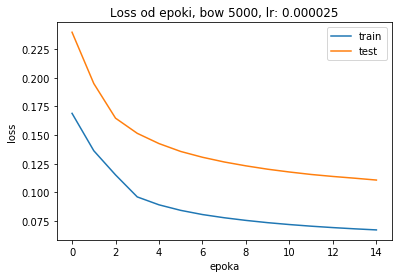

In [44]:
pylab.plot(loss2[5:], label="train")
pylab.plot(loss_test2[5:], label="test")
pylab.legend()
pylab.title('Loss od epoki, bow 5000, lr: 0.000025')
pylab.xlabel('epoka')
pylab.ylabel('loss')
loss_test2[9]

In [49]:
torch.save(model_rekomendacji.state_dict(), 'model_rekomendacji5000_0005.pt')

In [ ]:
frequencies = []
for i in range(50000):
    frequencies.append(wordfreq[most_freq[i]])

In [ ]:
pylab.plot(frequencies[5000:])

In [50]:
testloader = DataLoader(test, batch_size=len(df_test), shuffle=True)

In [51]:
for V,T,S,ID in testloader:
    torch.cuda.empty_cache()
    V=V.to(device)
    T=T.to(device)
    S=S.to(device)
    
    wx =model_rekomendacji.forward(V)
    
    wx=wx.tolist()
    T=T.tolist()
    ID=list(ID)
    
    WX=pd.DataFrame([ID,T,wx]).T

    break
    

In [52]:
WX['id'] = WX[0]
WX['type_real'] = WX[1]
WX['type_predicted'] = WX[2]
WX=WX.drop(columns=[0,1,2])
WX

,id,type_real,type_predicted
0,658c22b827981fb0f13b0b90c2a8e9,"[0.0, 1.0]","[0.9934641718864441, 0.0054617165587842464]"
1,cc9d81379171babe601d4161ab7890b2,"[0.0, 1.0]","[1.730234430397104e-06, 0.999998927116394]"
2,b4d28645cfc5d83928bb10ecd52dc60a,"[0.0, 1.0]","[0.0003212711017113179, 0.9997560381889343]"
3,86ce558e1498e95570832a5cd5879321,"[1.0, 0.0]","[0.9534833431243896, 0.04176231473684311]"
4,9657e2083522e486a6fb2243c56e15d2,"[1.0, 0.0]","[0.9998145699501038, 0.00013443334319163114]"
...,...,...,...
2635,30ed629e3724a73fdcbb77a1071b339d,"[0.0, 1.0]","[1.1406883970721537e-07, 0.9999998807907104]"
2636,684f545d591a2f7772e0227e92f27b89,"[1.0, 0.0]","[1.6751540897530504e-05, 0.9999873638153076]"
2637,b396175e68dfbd936e04d64df869f030,"[0.0, 1.0]","[0.39945271611213684, 0.5944679379463196]"
2638,5ad7d9941f5984bd92098740fba402a8,"[1.0, 0.0]","[0.9999998807907104, 6.39962252080295e-08]"


In [53]:
is_bot = []
is_human = []
is_bot_pred = []
is_human_pred = []
for i in range(len(WX)):
    is_bot.append(WX.iloc[i]['type_real'][0])
    is_human.append(WX.iloc[i]['type_real'][1])
    is_bot_pred.append(WX.iloc[i]['type_predicted'][0])
    is_human_pred.append(WX.iloc[i]['type_predicted'][1])

In [54]:
WX['is_bot'] = is_bot
WX['is_human'] = is_human
WX['is_bot_pred'] = is_bot_pred
WX['is_human_pred'] = is_human_pred

In [55]:
WX=WX.drop(columns=['type_real','type_predicted'])
WX

,id,is_bot,is_human,is_bot_pred,is_human_pred
0,658c22b827981fb0f13b0b90c2a8e9,0.0,1.0,9.934642e-01,5.461717e-03
1,cc9d81379171babe601d4161ab7890b2,0.0,1.0,1.730234e-06,9.999989e-01
2,b4d28645cfc5d83928bb10ecd52dc60a,0.0,1.0,3.212711e-04,9.997560e-01
3,86ce558e1498e95570832a5cd5879321,1.0,0.0,9.534833e-01,4.176231e-02
4,9657e2083522e486a6fb2243c56e15d2,1.0,0.0,9.998146e-01,1.344333e-04
...,...,...,...,...,...
2635,30ed629e3724a73fdcbb77a1071b339d,0.0,1.0,1.140688e-07,9.999999e-01
2636,684f545d591a2f7772e0227e92f27b89,1.0,0.0,1.675154e-05,9.999874e-01
2637,b396175e68dfbd936e04d64df869f030,0.0,1.0,3.994527e-01,5.944679e-01
2638,5ad7d9941f5984bd92098740fba402a8,1.0,0.0,9.999999e-01,6.399623e-08


In [56]:
WX.to_csv('wyniki2000test.csv')

# Klasyfikacja płci
Założenia: trafiają tu tylko dane oznakowane jako type: human

In [151]:
labels_human = labels.loc[labels['type']==1]

In [152]:
labels_human['sex'] -= 1

C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [153]:
df_human = df.iloc[labels_human.index]

In [154]:
labels_human_test = labels_test.loc[labels_test['type']==1]
labels_human_test['sex'] -= 1

C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
df_human_test = df_test.iloc[labels_human_test.index]

In [181]:
device=torch.device("cpu")
model_rekomendacji_sex = ModelNN()
model_rekomendacji_sex = model_rekomendacji_sex.to(device)

optim_parameters= [                
                {'params': model_rekomendacji_sex.linear1.parameters(),'lr': 0.00005},
                {'params': model_rekomendacji_sex.linear2.parameters(),'lr': 0.00005},
                {'params': model_rekomendacji_sex.linear3.parameters(),'lr': 0.00005},
                {'params': model_rekomendacji_sex.linear4.parameters(),'lr': 0.00005},
            ]

opt = optim.Adam(optim_parameters)

In [182]:
V = torch.tensor(df_human[[x for x in range(5000)]].values).double()
T = torch.tensor(labels_human['type'].values)
S = torch.tensor(labels_human['sex'].values)
ID = labels_human['user_id'].values

In [183]:
S

tensor([1, 1, 1,  ..., 0, 0, 0])

In [184]:
V_test = torch.tensor(df_human_test[[x for x in range(5000)]].values).double()
T_test = torch.tensor(labels_human_test['type'].values)
S_test = torch.tensor(labels_human_test['sex'].values)
ID_test = labels_human_test['user_id'].values

In [185]:
S_test

tensor([1, 1, 1,  ..., 0, 0, 0])

In [186]:
data = MyDataset(V,T,S,ID)
test = MyDataset(V_test,T_test,S_test,ID_test)

In [187]:
dataloader = DataLoader(data, batch_size=20, shuffle=True)
testloader = DataLoader(test, batch_size=10, shuffle=True)

for V,T,S,ID in dataloader:
    V = V.to(device)
    T = T.to(device)
    S = S.to(device)
    #label = label.to(device)
    #sex = sex.to(device)
    #sentence_vectors = sentence_vectors.to(device)
    wx = model_rekomendacji_sex.forward(V)
    print("PIERWSZY", mse_loss(wx, S))
    break
    
for V,T,S,ID in testloader:
    V = V.to(device)
    T = T.to(device)
    S = S.to(device)
    #label = label.to(device)
    #sex = sex.to(device)
    #sentence_vectors = sentence_vectors.to(device)
    wx = model_rekomendacji_sex.forward(V)
    print("PIERWSZY TEST", mse_loss(wx, S))
    
    break

PIERWSZY tensor([[0.2590, 0.2430],
        [0.2622, 0.2529],
        [0.2533, 0.2434],
        [0.2589, 0.2548],
        [0.2409, 0.2431],
        [0.2467, 0.2420],
        [0.2519, 0.2508],
        [0.2465, 0.2464],
        [0.2508, 0.2480],
        [0.2441, 0.2467],
        [0.2477, 0.2479],
        [0.2477, 0.2430],
        [0.2541, 0.2469],
        [0.2596, 0.2545],
        [0.2440, 0.2646],
        [0.2576, 0.2594],
        [0.2486, 0.2459],
        [0.2557, 0.2590],
        [0.2579, 0.2469],
        [0.2569, 0.2528]], grad_fn=<PowBackward0>)
PIERWSZY TEST tensor([[0.2468, 0.2481],
        [0.2418, 0.2421],
        [0.2449, 0.2607],
        [0.2603, 0.2529],
        [0.2417, 0.2438],
        [0.2507, 0.2642],
        [0.2480, 0.2481],
        [0.2644, 0.2394],
        [0.2500, 0.2595],
        [0.2501, 0.2477]], grad_fn=<PowBackward0>)


In [188]:
dataloader = DataLoader(data, batch_size=20, shuffle=True)
testloader = DataLoader(data, batch_size=50, shuffle=True)
loss = []
loss_test = []

EPOCHS=10
for e in range(EPOCHS):
    L_print=0
    L_print_test=0
            
    i=0
    for V,T,S,ID in tqdm(dataloader):
        
        V = V.to(device)
        T = T.to(device)
        S = S.to(device)
        
        wx = model_rekomendacji_sex.forward(V)
        
        L = mse_loss(wx, S).sum()
        
        opt.zero_grad()
        L.backward()
        opt.step()
        
        L_print+=L.item()
        i+=1
    j=0
    with torch.set_grad_enabled(False):
        for V,T,S,ID in testloader:
            V = V.to(device)
            T = T.to(device)
            S = S.to(device)
    #label = label.to(device)
    #sex = sex.to(device)
    #sentence_vectors = sentence_vectors.to(device)
            wx = model_rekomendacji_sex.forward(V)
            L_test = mse_loss(wx,S).sum()
            L_print_test+=L_test.item()
            j+=1
    
            
    loss.append(L_print/i)
    loss_test.append(L_print_test/j)
    
    print("Epoka :",e,"   Loss :",L_print/i,"    Loss test:",L_print_test/j)

  2%|█▌                                                                                | 2/103 [00:00<00:08, 11.81it/s]

Epoka : 0    Loss : 7.711302398477943     Loss test: 7.379853109518687


  1%|▊                                                                                 | 1/103 [00:00<00:10,  9.92it/s]

Epoka : 1    Loss : 2.040814333459706     Loss test: 1.7455734539599645


  1%|▊                                                                                 | 1/103 [00:00<00:10,  9.86it/s]

Epoka : 2    Loss : 0.43614815985693517     Loss test: 0.27568267813573283


  1%|▊                                                                                 | 1/103 [00:00<00:10,  9.87it/s]

Epoka : 3    Loss : 0.09461981963673696     Loss test: 0.13157026026220547


  1%|▊                                                                                 | 1/103 [00:00<00:11,  9.16it/s]

Epoka : 4    Loss : 0.05156494308606658     Loss test: 0.07853692166862034


  0%|                                                                                          | 0/103 [00:00<?, ?it/s]

Epoka : 5    Loss : 0.030164350845932383     Loss test: 0.06381847068578714


  1%|▊                                                                                 | 1/103 [00:00<00:10,  9.87it/s]

Epoka : 6    Loss : 0.025481214446187454     Loss test: 0.025455473523054804


  1%|▊                                                                                 | 1/103 [00:00<00:10,  9.92it/s]

Epoka : 7    Loss : 0.01013062177485904     Loss test: 0.012025863686132999


  1%|▊                                                                                 | 1/103 [00:00<00:10,  9.71it/s]

Epoka : 8    Loss : 0.004223979040370006     Loss test: 0.008113577244027207


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:12<00:00,  8.40it/s]


Epoka : 9    Loss : 0.0030421882775132953     Loss test: 0.006318439571519515


0.006318439571519515

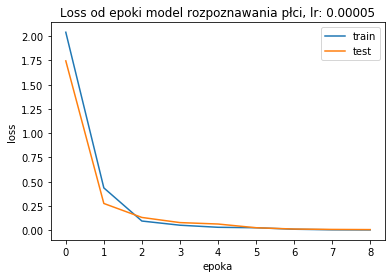

In [191]:
#lr = 0.00025
pylab.plot(loss[1:], label="train")
pylab.plot(loss_test[1:], label="test")
pylab.legend()
pylab.title('Loss od epoki model rozpoznawania płci, lr: 0.00005')
pylab.xlabel('epoka')
pylab.ylabel('loss')
loss_test[9]

In [192]:
torch.save(model_rekomendacji.state_dict(), 'model_rekomendacji_human_5000_0005.pt')

In [193]:
testloader = DataLoader(test, batch_size=len(df_test), shuffle=True)

for V,T,S,ID in testloader:
    torch.cuda.empty_cache()
    V=V.to(device)
    T=T.to(device)
    S=S.to(device)
    
    wx =model_rekomendacji_sex.forward(V)
    
    wx=wx.tolist()
    S=S.tolist()
    ID=list(ID)
    
    WX=pd.DataFrame([ID,S,wx]).T

    break

In [194]:
WX['id'] = WX[0]
WX['sex_real'] = WX[1]
WX['sex_predicted'] = WX[2]
WX=WX.drop(columns=[0,1,2])
WX

,id,sex_real,sex_predicted
0,bec20a7650d63bd6ef129289ed0af905,"[0.0, 1.0]","[0.0009211834985762835, 0.9990204572677612]"
1,dda53e664ff792fa6147b6716613268f,"[0.0, 1.0]","[0.008300154469907284, 0.9911065697669983]"
2,b3eaf37ee78f1b94cae4e585daf39384,"[1.0, 0.0]","[0.9998182654380798, 0.0002084121952066198]"
3,18bd56386e980d0d1a7ada8d3e0770ef,"[0.0, 1.0]","[0.5622705817222595, 0.44224366545677185]"
4,221b7aafc34cd24bedb6464dfdb76dff,"[0.0, 1.0]","[0.961206316947937, 0.041325926780700684]"
...,...,...,...
1315,cc413818f37c71c59f0d413d281ac5f5,"[0.0, 1.0]","[0.04055747017264366, 0.9594131708145142]"
1316,f776811b2f6adb7f9e9a05f243071edf,"[1.0, 0.0]","[0.9548304080963135, 0.04569306969642639]"
1317,e8ea99f04af73be9e107204105d96301,"[1.0, 0.0]","[0.9981133937835693, 0.002028928603976965]"
1318,953793075b04ac3bacb1428ceb19299,"[0.0, 1.0]","[0.02065816894173622, 0.97865891456604]"


In [195]:
is_male = []
is_female = []
is_male_pred = []
is_female_pred = []
for i in range(len(WX)):
    is_male.append(WX.iloc[i]['sex_real'][0])
    is_female.append(WX.iloc[i]['sex_real'][1])
    is_male_pred.append(WX.iloc[i]['sex_predicted'][0])
    is_female_pred.append(WX.iloc[i]['sex_predicted'][1])

In [196]:
WX['is_male'] = is_male
WX['is_female'] = is_female
WX['is_male_pred'] = is_male_pred
WX['is_female_pred'] = is_female_pred

In [197]:
WX = WX.drop(columns = ['sex_predicted', 'sex_real'])
WX

,id,is_male,is_female,is_male_pred,is_female_pred
0,bec20a7650d63bd6ef129289ed0af905,0.0,1.0,0.000921,0.999020
1,dda53e664ff792fa6147b6716613268f,0.0,1.0,0.008300,0.991107
2,b3eaf37ee78f1b94cae4e585daf39384,1.0,0.0,0.999818,0.000208
3,18bd56386e980d0d1a7ada8d3e0770ef,0.0,1.0,0.562271,0.442244
4,221b7aafc34cd24bedb6464dfdb76dff,0.0,1.0,0.961206,0.041326
...,...,...,...,...,...
1315,cc413818f37c71c59f0d413d281ac5f5,0.0,1.0,0.040557,0.959413
1316,f776811b2f6adb7f9e9a05f243071edf,1.0,0.0,0.954830,0.045693
1317,e8ea99f04af73be9e107204105d96301,1.0,0.0,0.998113,0.002029
1318,953793075b04ac3bacb1428ceb19299,0.0,1.0,0.020658,0.978659


In [198]:
WX.to_csv('wynikitest_sex.csv')

# analiza poprawności

In [199]:
type_predictions = pd.read_csv('wyniki2000test.csv').drop(columns = ['Unnamed: 0'])
sex_predictions = pd.read_csv('wynikitest_sex.csv').drop(columns = ['Unnamed: 0'])

In [200]:
res = []
for i in range(len(type_predictions)):
    if type_predictions['is_bot_pred'].iloc[i] > type_predictions['is_human_pred'].iloc[i]:
        res.append('bot')
    elif type_predictions['is_bot_pred'].iloc[i] < type_predictions['is_human_pred'].iloc[i]:
        res.append('human')
    else:
        res.append('not able to answer')

In [201]:
type_predictions['result'] = res
type_predictions

,id,is_bot,is_human,is_bot_pred,is_human_pred,result
0,658c22b827981fb0f13b0b90c2a8e9,0.0,1.0,9.934642e-01,5.461717e-03,bot
1,cc9d81379171babe601d4161ab7890b2,0.0,1.0,1.730234e-06,9.999989e-01,human
2,b4d28645cfc5d83928bb10ecd52dc60a,0.0,1.0,3.212711e-04,9.997560e-01,human
3,86ce558e1498e95570832a5cd5879321,1.0,0.0,9.534833e-01,4.176231e-02,bot
4,9657e2083522e486a6fb2243c56e15d2,1.0,0.0,9.998146e-01,1.344333e-04,bot
...,...,...,...,...,...,...
2635,30ed629e3724a73fdcbb77a1071b339d,0.0,1.0,1.140688e-07,9.999999e-01,human
2636,684f545d591a2f7772e0227e92f27b89,1.0,0.0,1.675154e-05,9.999874e-01,human
2637,b396175e68dfbd936e04d64df869f030,0.0,1.0,3.994527e-01,5.944679e-01,human
2638,5ad7d9941f5984bd92098740fba402a8,1.0,0.0,9.999999e-01,6.399623e-08,bot


In [202]:
res = []
for i in range(len(sex_predictions)):
    if sex_predictions['is_male_pred'].iloc[i] > sex_predictions['is_female_pred'].iloc[i]:
        res.append('male')
    elif sex_predictions['is_male_pred'].iloc[i] < sex_predictions['is_female_pred'].iloc[i]:
        res.append('female')
    else:
        res.append(' ')

In [203]:
sex_predictions['result'] = res
sex_predictions

,id,is_male,is_female,is_male_pred,is_female_pred,result
0,bec20a7650d63bd6ef129289ed0af905,0.0,1.0,0.000921,0.999020,female
1,dda53e664ff792fa6147b6716613268f,0.0,1.0,0.008300,0.991107,female
2,b3eaf37ee78f1b94cae4e585daf39384,1.0,0.0,0.999818,0.000208,male
3,18bd56386e980d0d1a7ada8d3e0770ef,0.0,1.0,0.562271,0.442244,male
4,221b7aafc34cd24bedb6464dfdb76dff,0.0,1.0,0.961206,0.041326,male
...,...,...,...,...,...,...
1315,cc413818f37c71c59f0d413d281ac5f5,0.0,1.0,0.040557,0.959413,female
1316,f776811b2f6adb7f9e9a05f243071edf,1.0,0.0,0.954830,0.045693,male
1317,e8ea99f04af73be9e107204105d96301,1.0,0.0,0.998113,0.002029,male
1318,953793075b04ac3bacb1428ceb19299,0.0,1.0,0.020658,0.978659,female


In [206]:
# predicted correctly: type

num_of_correct_type = 0
for i in range(len(type_predictions)):
    if type_predictions['is_bot'].iloc[i]:
        if type_predictions['result'].iloc[i] == 'bot':
            num_of_correct_type +=1
    elif type_predictions['is_human'].iloc[i]:
        if type_predictions['result'].iloc[i] == 'human':
            num_of_correct_type += 1
num_of_correct_type/len(type_predictions)

0.8837121212121212

In [210]:
# false humans

false_humans = 0
for i in range(len(type_predictions)):
    if type_predictions['is_bot'].iloc[i]:
        if type_predictions['result'].iloc[i] == 'human':
            false_humans +=1
false_humans/len(type_predictions)

0.0731060606060606

In [212]:
#  false bots
false_bots = 0
for i in range(len(type_predictions)):
    if type_predictions['is_human'].iloc[i]:
        if type_predictions['result'].iloc[i] == 'bot':
            false_bots += 1
false_bots/len(type_predictions)

0.03636363636363636

In [216]:
# predicted correctly: sex

num_of_correct_sex = 0
for i in range(len(sex_predictions)):
    if sex_predictions['is_male'].iloc[i]:
        if sex_predictions['result'].iloc[i] == 'male':
            num_of_correct_sex +=1
    elif sex_predictions['is_female'].iloc[i]:
        if sex_predictions['result'].iloc[i] == 'female':
            num_of_correct_sex += 1
num_of_correct_sex/len(sex_predictions)

0.775

In [217]:
# false males

false_males = 0
for i in range(len(sex_predictions)):
    if sex_predictions['is_female'].iloc[i]:
        if sex_predictions['result'].iloc[i] == 'male':
            false_males += 1
false_males/len(sex_predictions)

0.11893939393939394

In [218]:
# false females

false_females = 0
for i in range(len(sex_predictions)):
    if sex_predictions['is_male'].iloc[i]:
        if sex_predictions['result'].iloc[i] == 'female':
            false_females +=1
false_females/len(sex_predictions)

0.10606060606060606